In [129]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import zscore

In [101]:
# Reload the dataset
file_path = 'diabetes.csv'
data = pd.read_csv(file_path)

In [102]:
# Replace zero values with NaN in specified columns
columns_to_nullify = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']
data[columns_to_nullify] = data[columns_to_nullify].replace(0, np.nan)

# Handle missing values by imputing with median
imputer = SimpleImputer(strategy='median')
data[columns_to_nullify] = imputer.fit_transform(data[columns_to_nullify])

Используем Z-Score (3-5) для заполнения данных в Glucose, Blood Pressure, SkinThickness, BMI

In [103]:
# Detect and handle outliers using Z-score (for specific columns)
zscore_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for col in zscore_columns:
    z_scores = zscore(data[col])
    threshold = 3  # Define Z-score threshold
    max_val = data[col][z_scores <= threshold].max()
    data[col] = np.where(z_scores > threshold, max_val, data[col])

In [104]:
# Detect and handle outliers using IQR (for specific columns)
iqr_columns = ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
for col in iqr_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    max_val = data[col][data[col] <= upper_bound].max()
    data[col] = np.where(data[col] > upper_bound, max_val, data[col])

Используем IQR (1.5, 3) для заполнения данных в Pregnancies, Insulin, DiabetesPedigreeFunction, Age

In [105]:
# Normalize the data using Min-Max Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, :-1])  # Exclude the target column
X = pd.DataFrame(scaled_data, columns=data.columns[:-1])
y = data.iloc[:, -1]  # Target variable

In [106]:
# Balance the dataset by oversampling the minority class
class_counts = y.value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Oversampling: Duplicate samples from the minority class
minority_samples = X[y == minority_class]
minority_labels = y[y == minority_class]
oversampled_X = pd.concat([X, minority_samples.sample(class_counts[majority_class], replace=True)])
oversampled_y = pd.concat([y, minority_labels.sample(class_counts[majority_class], replace=True)])

In [107]:
# Train-test split (85% training, 15% test)
X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_y, test_size=0.15, random_state=42, stratify=oversampled_y)

In [108]:
# Train MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(1024, 512), max_iter=2000, random_state=64)
mlp_history = mlp_model.fit(X_train, y_train)
mlp_train_accuracy = accuracy_score(y_train, mlp_model.predict(X_train))
mlp_test_accuracy = accuracy_score(y_test, mlp_model.predict(X_test))

In [109]:
# Output results
print(
    f'MLP\n' + \
    f'Точность на обучающем наборе: {mlp_train_accuracy:.3f}\n' + \
    f'Точность на тестовом наборе: {mlp_test_accuracy:.3f}\n\n'
)

MLP
Точность на обучающем наборе: 0.873
Точность на тестовом наборе: 0.859




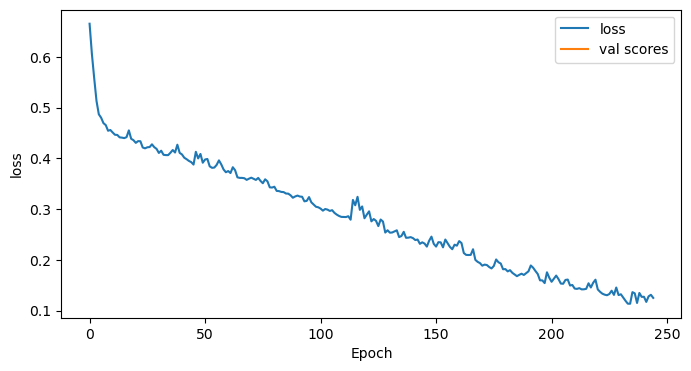

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(mlp_history.loss_curve_, label='loss')
plt.plot(mlp_history.loss_, label='val scores')
# plt.plot(mlp_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [110]:
custom_test = pd.read_csv('diabetes_test.csv')

# Normalize the data using Min-Max Scaling
scaler = MinMaxScaler()
custom_test_scaled = scaler.fit_transform(custom_test)  # Exclude the target column
X = pd.DataFrame(custom_test_scaled, columns=custom_test.columns)

display(X)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.000000,0.525641,0.428571,0.612903,0.262411,0.979310,0.002887,1.000000
1,0.266667,0.628205,0.000000,0.483871,0.368794,0.455172,0.131858,0.727273
2,0.000000,0.000000,0.964286,0.387097,0.000000,1.000000,0.093359,0.136364
3,0.200000,0.974359,0.500000,0.645161,0.351064,0.717241,0.047161,0.136364
4,0.266667,1.000000,0.428571,0.032258,0.468085,0.468966,0.203080,0.545455
5,0.200000,0.961538,0.214286,0.774194,0.670213,0.800000,0.198268,0.409091
6,0.600000,0.782051,1.000000,0.483871,0.421986,0.786207,1.000000,0.954545
7,0.400000,0.500000,0.428571,0.322581,0.333333,0.862069,0.377286,0.363636
8,0.200000,0.153846,0.142857,0.000000,0.042553,0.000000,0.508181,0.090909
9,0.266667,0.179487,0.214286,1.000000,0.223404,0.820690,0.726660,0.227273


In [111]:
mlp_history.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([
    # Dense(32, activation='relu', input_shape=(8,)),
    # BatchNormalization(),
    # Dropout(0.3),

    # Dense(16, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    # Dense(8, activation='relu'),
    # Dropout(0.2),

    Dense(16, activation='relu', input_shape=(8,)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.004),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                     │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [155]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=60,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4682 - loss: 0.7488 - val_accuracy: 0.5340 - val_loss: 0.6909
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.6934 - val_accuracy: 0.6021 - val_loss: 0.6712
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5916 - loss: 0.6684 - val_accuracy: 0.6073 - val_loss: 0.6550
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5937 - loss: 0.6584 - val_accuracy: 0.6073 - val_loss: 0.6433
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5981 - loss: 0.6514 - val_accuracy: 0.6073 - val_loss: 0.6360
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6315 - loss: 0.6427 - val_accuracy: 0.6073 - val_loss: 0.6312
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6168 - loss: 0.6504 - val_accuracy: 0.6073 - val_loss: 0.6278
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.6375 - val_accuracy: 0.6073 - v

In [156]:
print(
    f'Evaluate accuracy: {model.evaluate(X_test, y_test)[1]:.2f} \n' + \
    f'Predict list: {model.predict(X_test).round().T[0]}'
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8143 - loss: 0.4102
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Evaluate accuracy: 0.81 
Predict list: [0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.]


In [157]:
# Получение нужных данных с истори обучения модели
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epoch numbers

# Задание графика
fig = go.Figure()

# Добавление линии accuracy
fig.add_trace(go.Scatter(
    x=list(epochs),
    y=accuracy,
    mode='lines+markers',
    name='Training Accuracy',
    line=dict(color='blue', width=2),
    marker=dict(size=6)
))

# Добавление линии Validation accuracy 
fig.add_trace(go.Scatter(
    x=list(epochs),
    y=val_accuracy,
    mode='lines+markers',
    name='Validation Accuracy',
    line=dict(color='orange', width=2),
    marker=dict(size=6)
))

# Обновление лэйаута
layout = go.Layout(
    # margin_pad = 10,
    xaxis=dict(
        title = 'Epochs',
        tickvals=list(epochs),
        autorange=False,
        range=[0, len(list(epochs)) - 1],
        tick0=0,
        dtick=1,
        tickmode='linear'  # Чтобы эпохи показывались как целые числа
    ),
    title='Training and Validation Accuracy',
    yaxis_title='Accuracy',
    legend_title='Metrics',
    template='plotly_white'
)
fig.update_layout(layout)

fig.show()

In [158]:
predictions = model.predict(X_test).round().T[0]
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictions))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.84      0.64      0.73        75
           1       0.80      0.92      0.86       116

    accuracy                           0.81       191
   macro avg       0.82      0.78      0.79       191
weighted avg       0.82      0.81      0.81       191



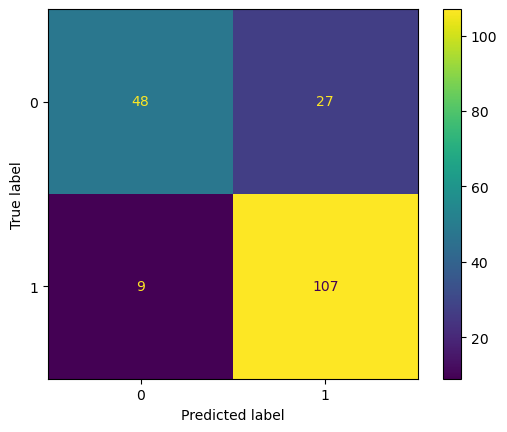

In [159]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)